# Install modules

In [1]:
import spectogramConverter as sc

In [1]:
!pip install shap

In [2]:
# Import modules
import tensorflow as tf
import tensorflow.keras as K

from tensorflow.keras.applications import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

import numpy as np
import librosa.display, os
import keras.utils as image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow_hub as hub
import datetime
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# For XAI
import lime
from skimage.segmentation import mark_boundaries

from tensorflow import keras
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
import requests
from skimage.segmentation import slic
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import shap
import warnings

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [6]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    %matplotlib inline
    plt.imshow(mark_boundaries(image, mask))
    plt.plot()

# Load data

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

def convert_audio_to_spectrogram(audio_file, output_dir):
    # Load the audio file
    y, sr = librosa.load(audio_file)

    # Generate a Mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Save the spectrogram as an image
    file_name = os.path.splitext(os.path.basename(audio_file))[0]
    output_path = os.path.join(output_dir, f"{file_name}.png")
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

# Example usage:
# audio_file_path = "example_audio.wav"
# output_directory = "/content/Spectrograms"
# os.makedirs(output_directory, exist_ok=True)
# convert_audio_to_spectrogram(audio_file_path, output_directory)

In [8]:
# Load data parameters
tf.random.set_seed(42)

batch_size = 32
img_height = img_width = 224
channels = 3
epochs = 20
input_shape = (224, 224, 3)

# root = '/content/Spectrogram' #r'path_to_Spectrogram_folder' 
# Add multiple folders
root = [
    sc.spect_train_directory_real+'/',
    sc.spect_train_directory_fake+'/',
    sc.spect_test_directory_fake+'/',
    sc.spect_test_directory_real+'/',
    sc.spect_val_directory_fake+'/',
    sc.spect_val_directory_real+'/'
]

# Example: Iterate over the folders
# for folder in root:
#     print(f"Processing folder: {folder}")

In [9]:
def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(img_to_array(load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

x = []
y = []

In [10]:
images, labels = load_images_from_path(sc.spect_test_directory_fake, 0)
# show_images(images)
    
x += images
y += labels

images, labels = load_images_from_path(sc.spect_train_directory_fake, 0)
# show_images(images)
    
x += images
y += labels

images, labels = load_images_from_path(sc.spect_val_directory_fake, 0)
# show_images(images)
    
x += images
y += labels

In [11]:
images, labels = load_images_from_path(sc.spect_test_directory_real, 1)
# show_images(images)
    
x += images
y += labels

images, labels = load_images_from_path(sc.spect_train_directory_real, 1)
# show_images(images)
    
x += images
y += labels

images, labels = load_images_from_path(sc.spect_val_directory_real, 1)
# show_images(images)
    
x += images
y += labels

In [12]:
# train_ds = K.utils.image_dataset_from_directory(str(root), 
#                                                validation_split = 0.2,
#                                                subset = 'training',
#                                                seed = 42,
#                                                image_size = (img_height, img_width),
#                                                batch_size = batch_size)

# test_ds = K.utils.image_dataset_from_directory(str(root), 
#                                                validation_split = 0.2,
#                                                subset = 'validation',
#                                                seed = 42,
#                                                image_size = (img_height, img_width),
#                                                batch_size = batch_size)

# Assuming `y` contains labels: 0 for 'fake' and 1 for 'real'
class_names = np.array(['fake', 'real'])

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print("Class names:", class_names)
print(f"Training samples: {len(x_train)}, Testing samples: {len(x_test)}")

# # Initialize empty lists for datasets
# train_datasets = []
# test_datasets = []

# # Iterate over each directory and load the dataset
# for folder in root:
#     train_dataset = K.utils.image_dataset_from_directory(
#         folder,
#         validation_split=0.2,
#         subset='training',
#         seed=42,
#         image_size=(img_height, img_width),
#         batch_size=batch_size
#     )
#     test_dataset = K.utils.image_dataset_from_directory(
#         folder,
#         validation_split=0.2,
#         subset='validation',
#         seed=42,
#         image_size=(img_height, img_width),
#         batch_size=batch_size
#     )
#     train_datasets.append(train_dataset)
#     test_datasets.append(test_dataset)

# # Combine all datasets
# train_ds = train_datasets[0].concatenate(*train_datasets[1:])
# test_ds = test_datasets[0].concatenate(*test_datasets[1:])

Class names: ['fake' 'real']
Training samples: 10614, Testing samples: 2654


In [13]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array

# Example data loading function
def load_images_from_path(path, label):
    images = []
    labels = []
    for file in os.listdir(path):
        if file.endswith(('.png', '.jpg', '.jpeg')):  # Load only valid image files
            images.append(img_to_array(load_img(os.path.join(path, file), target_size=(224, 224, 3))))
            labels.append(label)
    return images, labels

# Manually load data
x = []
y = []

# Assuming `sc.spect_*` contains paths to real and fake data directories
# Fake data
for directory, label in [
    (sc.spect_test_directory_fake, 0),
    (sc.spect_train_directory_fake, 0),
    (sc.spect_val_directory_fake, 0),
]:
    images, labels = load_images_from_path(directory, label)
    x += images
    y += labels

# Real data
for directory, label in [
    (sc.spect_test_directory_real, 1),
    (sc.spect_train_directory_real, 1),
    (sc.spect_val_directory_real, 1),
]:
    images, labels = load_images_from_path(directory, label)
    x += images
    y += labels

# Convert to NumPy arrays
x = np.array(x)
y = np.array(y)

# Split into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Batch and preprocess the data
batch_size = 32

def preprocess_data(x, y):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_ds = preprocess_data(x_train, y_train)
test_ds = preprocess_data(x_test, y_test)

# Class names
class_names = np.array(['fake', 'real'])
print("Class names:", class_names)

# Print dataset details
print(f"Training samples: {len(x_train)}, Testing samples: {len(x_test)}")

# Inspect a batch
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)  # Shape of a batch of images
    print(labels_batch.shape)  # Shape of a batch of labels
    break

# Calculate steps per epoch and validation steps
total_train_samples = len(x_train)
steps_per_epoch = tf.math.ceil(total_train_samples / batch_size)

total_test_samples = len(x_test)
validation_steps = tf.math.ceil(total_test_samples / batch_size)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Class names: ['fake' 'real']
Training samples: 10614, Testing samples: 2654
(32, 224, 224, 3)
(32,)
Steps per epoch: 332.0
Validation steps: 83.0


In [14]:
# 32 (224*224*3) sized images in 1 batch
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [15]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(10614, 224, 224, 3) (10614,)
(2654, 224, 224, 3) (2654,)


In [16]:
total_train_samples = len(x_train)
steps_per_epoch = int(tf.math.ceil(total_train_samples / batch_size))

In [17]:
total_val_samples = len(x_test)
validation_steps = int(tf.math.ceil(total_val_samples / batch_size))

# VGG16

In [18]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [19]:
for layer in vgg16.layers:
    layer.trainable = False

In [20]:
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [21]:
model_vgg = Model(inputs=vgg16.input, outputs=x)

In [22]:
model_vgg.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

In [23]:
model_vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
history_vgg16 = model_vgg.fit(
    x_train, y_train, 
    epochs=10, 
    batch_size=32, 
    validation_data=(x_test, y_test)
)

Epoch 1/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 808s 2s/step - accuracy: 0.6573 - loss: 3.0849 - val_accuracy: 0.8538 - val_loss: 0.5479
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - accuracy: 0.8147 - loss: 0.7499 - val_accuracy: 0.8821 - val_loss: 0.3387
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 814s 2s/step - accuracy: 0.8499 - loss: 0.4208 - val_accuracy: 0.8926 - val_loss: 0.2882
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 818s 2s/step - accuracy: 0.8848 - loss: 0.2827 - val_accuracy: 0.8975 - val_loss: 0.2517
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 819s 2s/step - accuracy: 0.9005 - loss: 0.2369 - val_accuracy: 0.9096 - val_loss: 0.2312
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 823s 2s/step - accuracy: 0.9258 - loss: 0.1958 - val_accuracy: 0.9182 - val_loss: 0.2168
Epoch 7/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 845s 3s/step - accuracy: 0.9280 - loss: 0.1696 - val_accuracy: 0.9243 - val_loss: 0.2067
Epoch 8/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 877s 3s/step - accuracy: 0.9455 - loss: 0.1386 - val_accu

In [26]:
loss, accuracy = model_vgg.evaluate(x_test, y_test)
print('Validation accuracy:', accuracy)

83/83 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9282 - loss: 0.1886
Validation accuracy: 0.9325546622276306


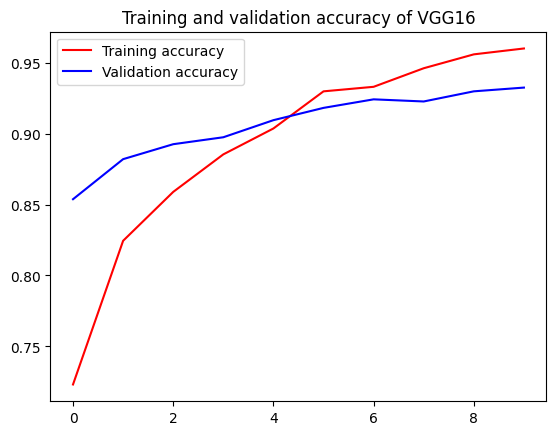

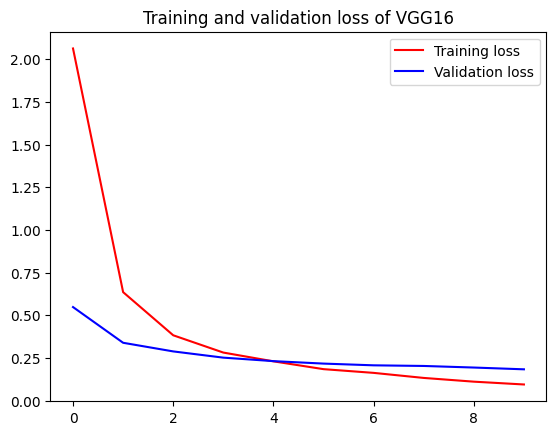

In [27]:
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy of VGG16')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of VGG16')
plt.legend()

plt.show()

In [28]:
predicted_batch = model_vgg.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print('VGG:',predicted_label_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
VGG: ['fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake']


In [30]:
model_vgg.save_weights(sc.main_directory+'VGG/my_checkpoint.weights.h5')
model_vgg.save(sc.main_directory+ 'VGG/my_model.h5')